- Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single state (each member should choose different state) and its counties (top 5 with highest number of cases). Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday). 
    - X-Axis - number of days, Y-Axis number of new cases and deaths. Calcluate error using RMSE.(10 points)
    - Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends. (10 points)
    - Perform hypothesis tests on questions identified in Stage III. (30 points)
        - e.x. *Does higher employment data (overall employment numbers) lead to higher covid case numbers or more rapid increase in covid cases.*. Here you would compare the covid cases to the state or county level enrichment data to prove or disprove your null hypothesis. In this case there will be a two tail - two sample t-test to see if there is a difference and then one-tail - two sample t-test to show higher or lower.
        - you can also make 3 new hypotheses and do hypothesis tests on them.
        - Depending on your type of data you can also perform Chi-square test for categorical hypothesis testing. 

In [1]:
#!pip install --user ipykernel
#!pip install sktime
#!pip install ipython
#!pip install -U kaleido
#!pip install --user ..\\kaleido-0.1.0.post1-py2.py3-none-win_amd64.whl

In [2]:
# imports
import pandas as pd
import numpy as np
import datetime

In [3]:
# read in csv files
cases = pd.read_csv("../covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../covid_deaths_usafacts.csv")
population = pd.read_csv("../Full_Covid_Data.csv")

In [4]:
# Functions for state stuffs
def parse_datetime_state(full_data, state):
    #get date range for chosen state
    state_data = full_data[full_data['State'] == state]
    dates = state_data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in state_data]] #Extract non dates
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def parse_datetime_county(full_data, county):
    #get date range for chosen state
    county_data = full_data[full_data['County Name'] == county]
    dates = county_data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in county_data]] #Extract non dates
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

### Set up state data & counties

In [5]:
state = 'SC'
norm_factor = 10000

pop_SC = population.loc[population["State"] == state]
pop_SC_sum = pop_SC['population'].sum()

cases_dates_SC = parse_datetime_state(cases, state)
deaths_dates_SC = parse_datetime_state(deaths, state)
cases_weeks_SC = get_weekly(cases_dates_SC)
deaths_weeks_SC = get_weekly(deaths_dates_SC)

In [6]:
county_names = ["Charleston County ", "Greenville County ", "Horry County ", "Richland County ", "Spartanburg County "]
cases_counties = cases[(cases['State'] == state)&(cases['County Name'].isin(county_names))]
deaths_counties = deaths[(deaths['State'] == state)&(deaths['County Name'].isin(county_names))]
county_pop = pop_SC.loc[cases['County Name'].isin(county_names),(pop_SC.columns.isin(["population"]))]
county_cweeks = []
county_dweeks = []
norm_factor = 1000
for i in range (5) :
    county_dates = parse_datetime_county(cases_counties, county_names[i])
    county_cweeks.append(get_weekly(county_dates))
    county_dates = parse_datetime_county(deaths_counties, county_names[i])
    county_dweeks.append(get_weekly(county_dates))


## Regression

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import IPython

In [8]:
# Regression plot function (does both linear and polynomial)
def create_reg_plot(data_weekly, degree = 1, title = None, dc = None):
    #data_dates = get_dates(data)
    #data_weekly = get_weekly(data_dates)
    #Make cases have an int rather than a date for regression.
    data_weekly["week"] = [i for i in range(len(data_weekly))]
    X = data_weekly["week"]
    y = data_weekly["sum"]
    
    y_train, y_test = temporal_train_test_split(y, test_size=1)
    poly_features = PolynomialFeatures(degree = degree)
    regressor = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
    
    forecaster.fit(y_train)
    y_predict = forecaster.predict(fh)
    
    std_error = np.sqrt(mean_squared_error(y_test,y_predict)) 
    intervel = 1.96 * std_error
    
    # Get regression line
    X = np.array(data_weekly["week"]).reshape(-1,1)
    X_poly = poly_features.fit_transform(X)
    #print(X_poly)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, data_weekly["sum"])
    
    X_reg = poly_features.fit_transform(np.array([i for i in range(len(data_weekly))]).reshape(-1,1))
    X_plot = np.array([i for i in range(len(data_weekly))]).reshape(-1,1)
    y_reg = lin_reg.predict(X_reg)
    
    reg_df = pd.DataFrame(X_plot, columns = ["X_plot"])
    y_frame = pd.DataFrame(y_reg, columns = ["y_reg"])
    
    reg_df = reg_df.join(y_frame)
    
    #Initial plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines+markers', name="previous data"))
    fig.add_trace(go.Scatter(x=reg_df["X_plot"], y=reg_df["y_reg"], mode='lines', name="regression line"))
    fig.add_trace(go.Scatter(x=y_predict.index, y=y_predict, mode='lines+markers', name="predicted values",
                            error_y = {"type": "constant", "value": intervel}))
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines+markers', name="true values"))
        
    if (dc == 'c') :
        dc = "Cases"
    elif (dc == 'd') :
        dc = "Deaths"
    else :
        dc = "Cases/Deaths"
    fig.update_layout(xaxis_title='Week', yaxis_title=('New {}'.format(dc)))
    if title != None:
        #plt.title(title)
        fig.update_layout(title = title)
    #pio.write_image(fig, "figure.png")
    #fig.show()
    IPython.display.display(IPython.display.Image(fig.to_image(format = "png"))) #Return static image for viewing
    print("RMSE: {}".format(std_error))
    return fig
degree = 4

### Linear vs Non-linear Regression: Cases

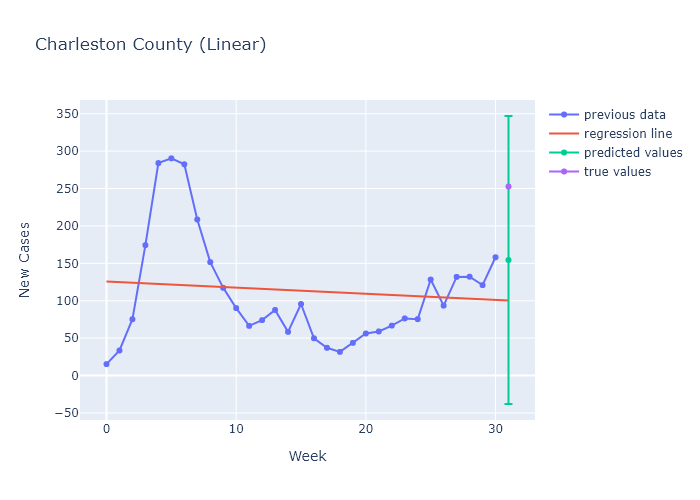

RMSE: 98.21492090355332


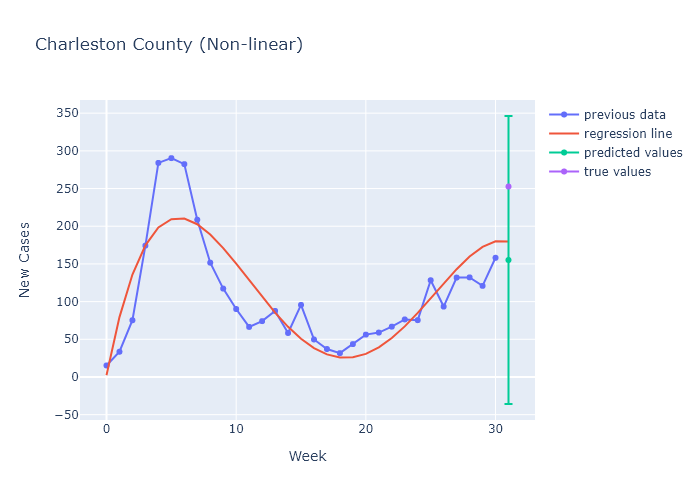

RMSE: 97.47693665435051


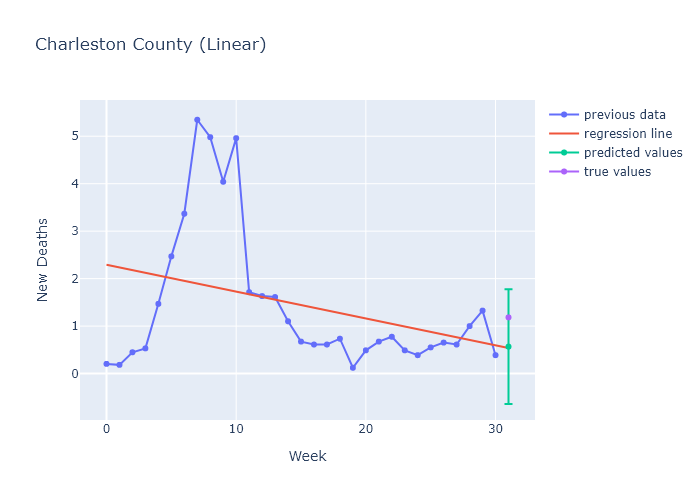

RMSE: 0.6163518489556885


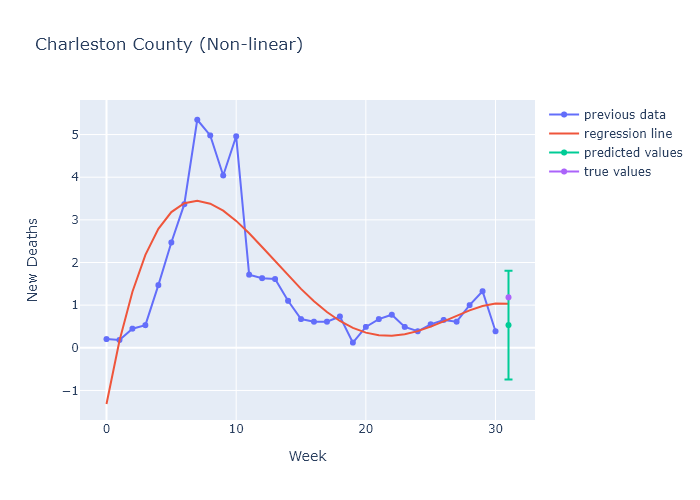

RMSE: 0.6509713481612388


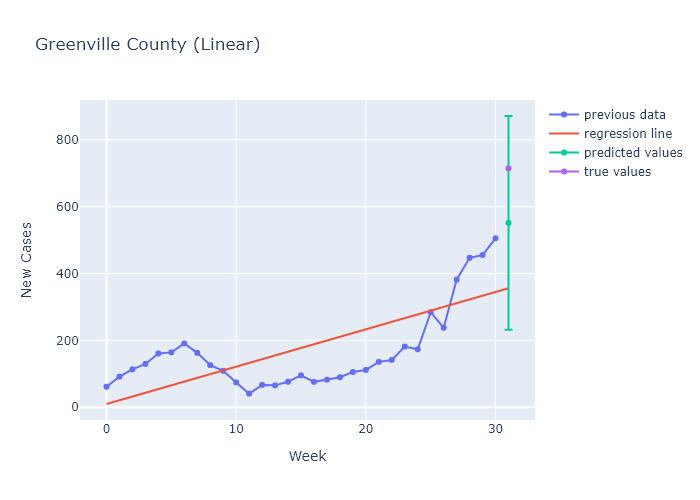

RMSE: 163.13155563525788


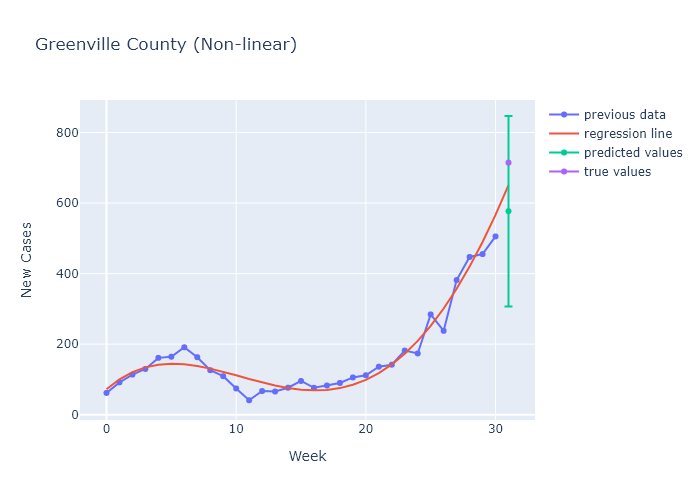

RMSE: 137.74926309997818


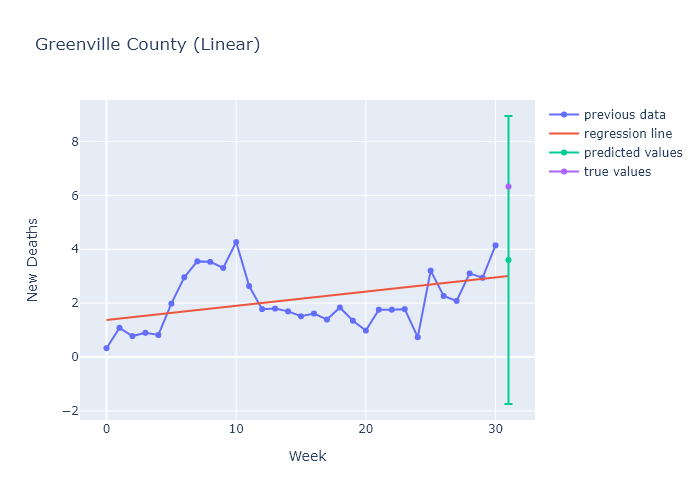

RMSE: 2.726845238559148


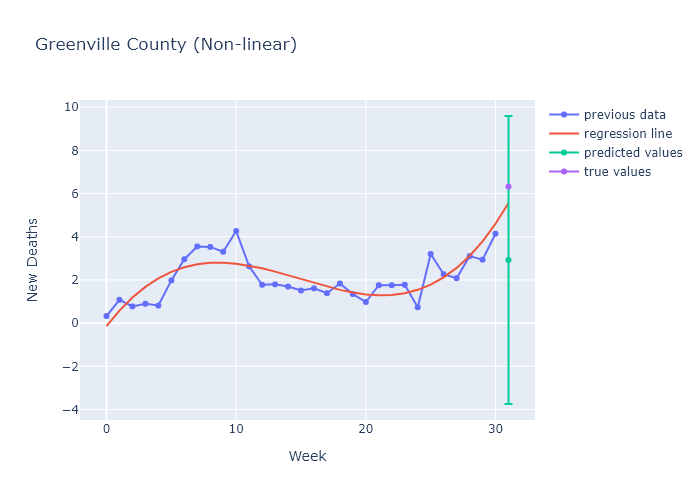

RMSE: 3.402324098351545


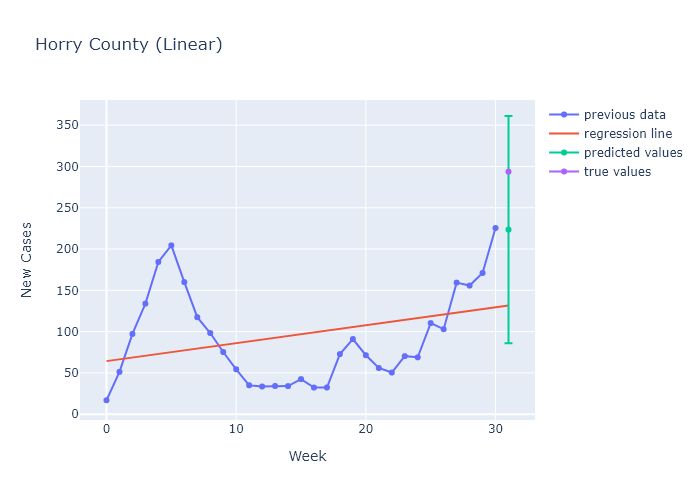

RMSE: 70.23875812223204


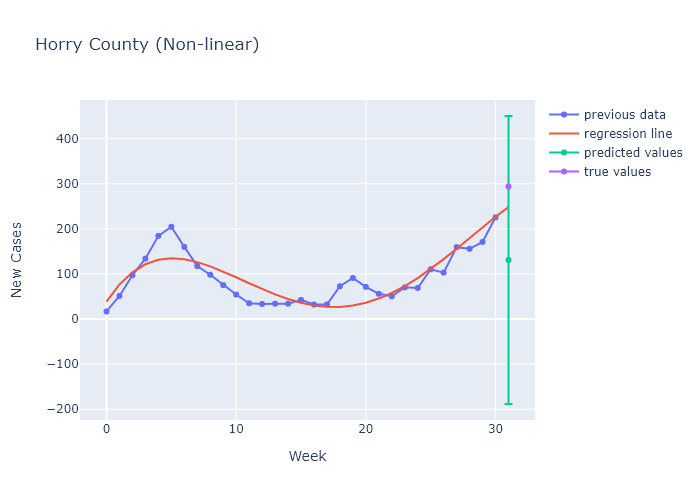

RMSE: 162.84135328908155


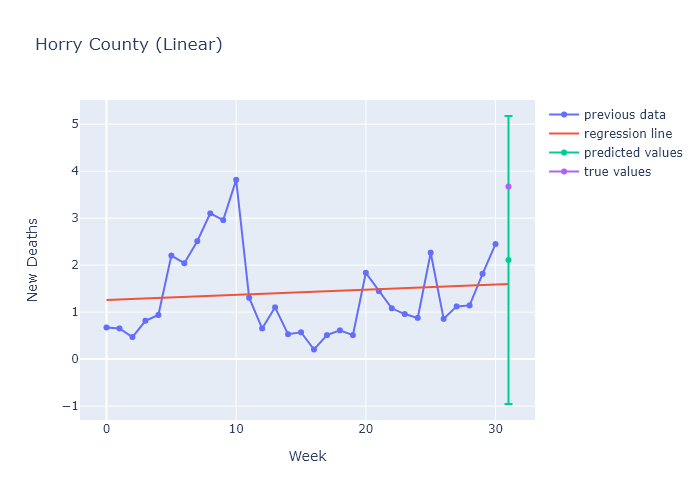

RMSE: 1.5638128422100546


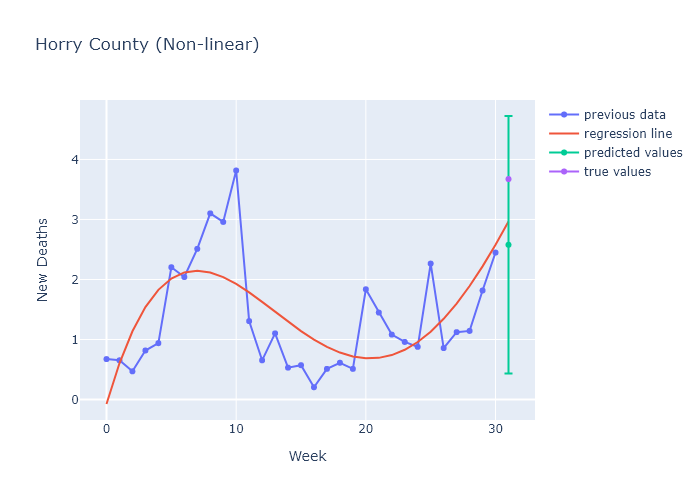

RMSE: 1.0948262513680924


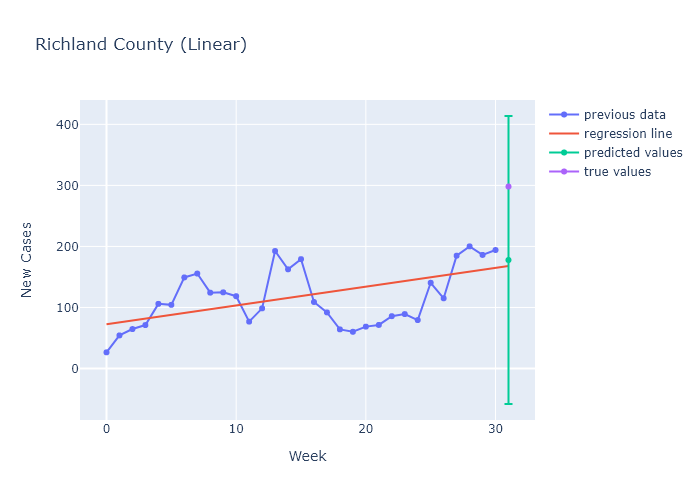

RMSE: 120.36742166778782


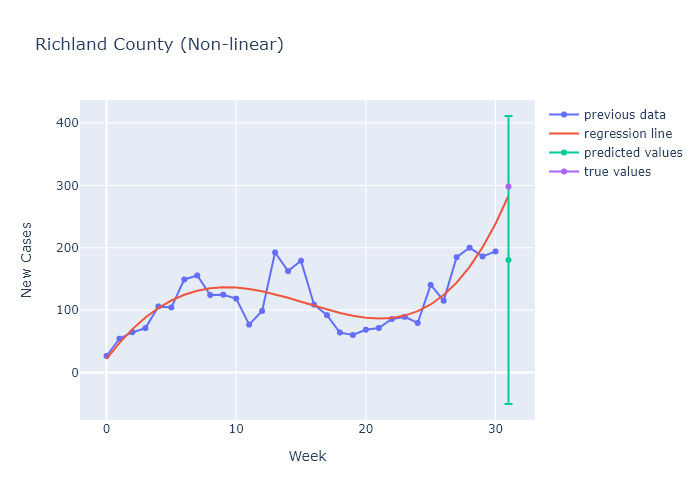

RMSE: 117.77652786286484


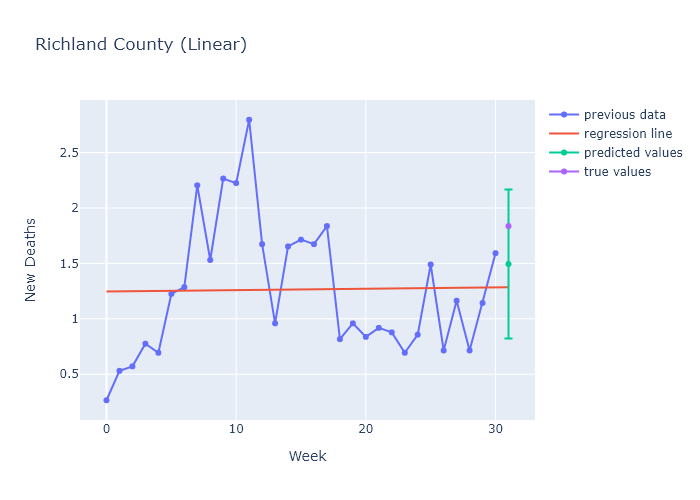

RMSE: 0.34255214652909394


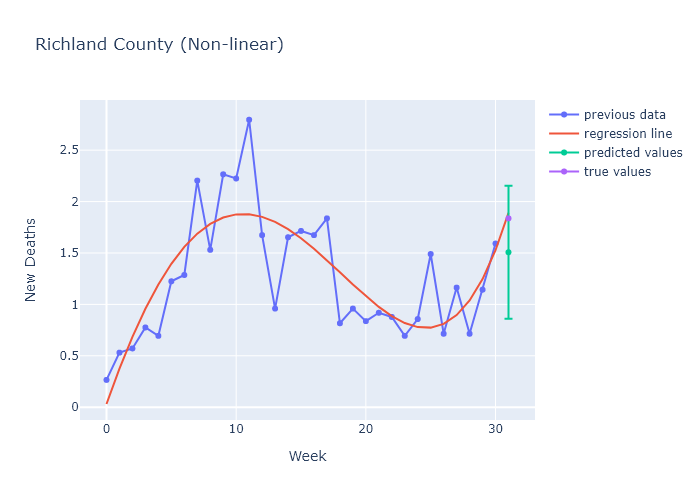

RMSE: 0.3296923697425349


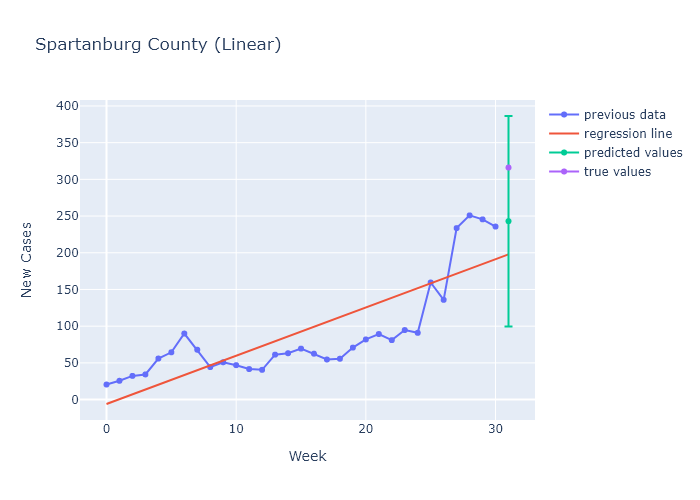

RMSE: 73.12406196378896


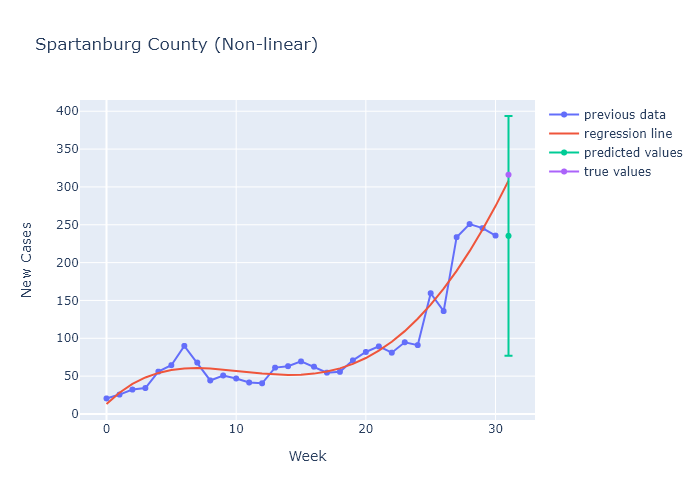

RMSE: 80.8261548706426


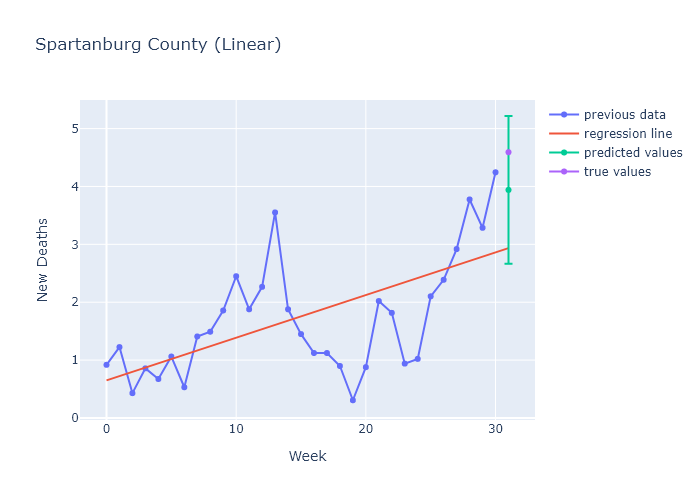

RMSE: 0.6517955726195765


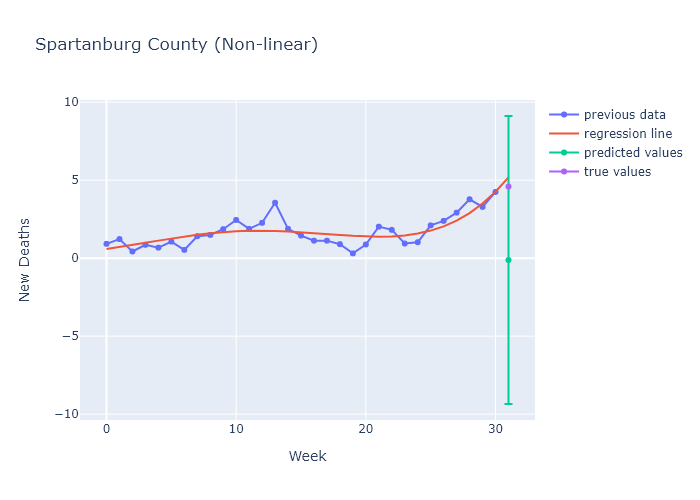

RMSE: 4.709504867599805


In [9]:
for i in range (5) :
    dc = 'c' #deaths or cases - cases
    fig = create_reg_plot(county_cweeks[i], title = ("{}(Linear)".format(county_names[i])), dc = dc)
    pio.write_image(fig, "county_images/{}Cases Linear.jpeg".format(county_names[i]))
    fig = create_reg_plot(county_cweeks[i], degree = degree, title = ("{}(Non-linear)".format(county_names[i])), dc = dc)
    pio.write_image(fig, "county_images/{}Cases Nonlinear.jpeg".format(county_names[i]))
    
    dc = 'd' #deaths or cases - deaths
    fig = create_reg_plot(county_dweeks[i], title = ("{}(Linear)".format(county_names[i])), dc = dc)
    pio.write_image(fig, "county_images/{}Deaths Linear.jpeg".format(county_names[i]))
    fig = create_reg_plot(county_dweeks[i], degree = degree, title = ("{}(Non-linear)".format(county_names[i])), dc = dc)
    pio.write_image(fig, "county_images/{}Deaths Nonlinear.jpeg".format(county_names[i]))

The only county that had a negative regression line was Charleston County. All other counties had a rising trend in their data. Each county had a peak in cases before week 10, with a dip before rising again around week 15-20.

## T-test - Employment & COVID-19

In [10]:
employment = pd.read_csv("Employment/Merge_Covid_Employment.csv")
covid = employment.loc[:, "2020-05-25_cases":"2021-01-10_cases"]
covid["State"] = employment["State"]
covid["County Name"] = employment["County Name"]
employment.drop(employment.iloc[:,4:2537], axis=1, inplace=True)
employment = employment.dropna(axis=0)
covid = covid.dropna(axis=0)
#working with mostly 2020 data here, so we can drop 2021 & 2022
employment = employment[employment.columns.drop(employment.filter(regex='2022'))]

C:\Users\leapi\AppData\Local\Temp\ipykernel_18452\949405052.py:1: DtypeWarning:

Columns (1,2,3,1270,2537) have mixed types. Specify dtype option on import or set low_memory=False.



In [11]:
#get population of each county & state

cov = covid.loc[covid["State"]==state]
emp = employment.loc[employment["State"]==state]
pop_SC_sum = emp['population'].sum()

emp = emp.iloc[2:,:] #Statewide Unallocated shows up twice in each dataset. take both out
cov = cov.iloc[2:,:]

In [12]:
emp_cols = ["County Name", "population", "annual_avg_emplvl", 
            "taxable_annual_wages", "annual_avg_estabs_count"]
cont = [col for col in emp.columns if any(item in col for item in emp_cols)]
emp = emp.loc[:,emp.columns.isin(cont)]
emp = emp[emp.columns.drop(emp.filter(regex='_deaths'))]
emp = emp[emp.columns.drop(emp.filter(regex='pct_chg'))]

In [13]:
# Cumulative state employment data
emp_state = pd.DataFrame(columns = ["population", "annual_avg_emplvl_2020", 
            "taxable_annual_wages_2020", "annual_avg_estabs_count_2020", "annual_avg_emplvl_2021", 
            "taxable_annual_wages_2021", "annual_avg_estabs_count_2021"])
emp_state = emp_state.append({"population" : emp["annual_avg_emplvl_2020"].sum(), 
                      "annual_avg_emplvl_2020" : emp["annual_avg_emplvl_2020"].sum(),
                      "taxable_annual_wages_2020" : emp["taxable_annual_wages_2020"].sum(),
                      "annual_avg_estabs_count_2020" : emp["annual_avg_estabs_count_2020"].sum(),
                      "annual_avg_emplvl_2021" : emp["annual_avg_emplvl_2021"].sum(),
                      "taxable_annual_wages_2021" : emp["taxable_annual_wages_2021"].sum(),
                      "annual_avg_estabs_count_2021" : emp["annual_avg_estabs_count_2021"].sum()}, 
                      ignore_index = True)

C:\Users\leapi\AppData\Local\Temp\ipykernel_18452\1292530450.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [14]:
emp_cn = []
for i in range(len(county_names)) :
    emp_cn.append(county_names[i][:(len(county_names[i])-1)])
emp_counties = emp.loc[emp["County Name"].isin(emp_cn)]

### T-test: counties

In [25]:
# 1- & 2-tail t-test
import scipy.stats as stats
hypothesis = ["emplvl", "taxable_annual_wages", "estabs_count"]
print("**Null hypothesis:",
      "there is no correlation between levels of employment variables\n", hypothesis,
      "\n and COVID-19 cases in these counties\n")
emp_counties.index = [i for i in range(len(emp_counties["County Name"]))]
for j in range (len(hypothesis)) :
    cont = [col for col in emp_counties.columns if any(item in col for item in ["{}_202".format(hypothesis[j])])]
    print("--- {} -------------------------------------------------------------".format(hypothesis[j]))
    for i in range (5) :
        d1 = emp_counties[cont].iloc[i]
        d2 = county_cweeks[i]["sum"]
        _, pval = stats.ttest_ind(d1, d2, equal_var=False)
        print("{}: {}\n2-tailed p-value =\t{}".format(emp_cn[i], hypothesis[j], pval))
        if (pval < 0.05) :
            print("STATISTICALLY SIGNIFICANT (null rejected)\n")
        else :
            print("not statistically significant\n")
        _, pval = stats.ttest_ind(d1, d2, equal_var=False, alternative=alt)
        print("1-tailed p-value =\t{}".format(pval))
        if (pval < 0.05) :
            print("STATISTICALLY SIGNIFICANT (alternative accepted: {})\n\n".format(alt))
        else :
            print("not statistically significant (not {})\n\n".format(alt))

**Null hypothesis: there is no correlation between levels of employment variables
 ['emplvl', 'taxable_annual_wages', 'estabs_count'] 
 and COVID-19 cases in these counties

--- emplvl -------------------------------------------------------------
Charleston County: emplvl
2-tailed p-value =	0.01293460849111998
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value =	0.00646730424555999
STATISTICALLY SIGNIFICANT (alternative accepted: greater)


Greenville County: emplvl
2-tailed p-value =	0.010802822113256162
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value =	0.005401411056628081
STATISTICALLY SIGNIFICANT (alternative accepted: greater)


Horry County: emplvl
2-tailed p-value =	0.01906325748423449
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value =	0.009531628742117245
STATISTICALLY SIGNIFICANT (alternative accepted: greater)


Richland County: emplvl
2-tailed p-value =	0.006866633985532277
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value =	0.003433

### T-test: state

In [23]:
# 1- & 2-tailed t-test: state
print("**Null hypothesis:",
      "there is no correlation between levels of employment variables:")
[print(" -",i) for i in hypothesis]
print("and COVID-19 cases in these counties\n")
for j in range (len(hypothesis)) :
    cont = [col for col in emp_counties.columns if any(item in col for item in ["{}_202".format(hypothesis[j])])]
    print("--- {} {} -------------------------------------------------------------".format(state, hypothesis[j]))
    d1 = emp_state[cont].iloc[0]
    d2 = cases_weeks_SC["sum"]
    _, pval = stats.ttest_ind(d1, d2, equal_var=False)
    print("2-tailed p-value = {}".format(pval))
    if (pval < 0.05) :
        print("STATISTICALLY SIGNIFICANT (null rejected)\n")
    else :
        print("not statistically significant\n")
    _, pval = stats.ttest_ind(d1, d2, equal_var=False, alternative=alt)
    print("1-tailed p-value = {}".format(pval))    
    if (pval < 0.05) :
        print("STATISTICALLY SIGNIFICANT (alternative accepted: {})\n\n".format(alt))
    else :
        print("not statistically significant (not {})\n\n".format(alt))

**Null hypothesis: there is no correlation between levels of employment variables:
 - emplvl
 - taxable_annual_wages
 - estabs_count
and COVID-19 cases in these counties

--- SC emplvl -------------------------------------------------------------
2-tailed p-value = 0.008650201929172987
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value = 0.004325100964586493
STATISTICALLY SIGNIFICANT (alternative accepted: greater)


--- SC taxable_annual_wages -------------------------------------------------------------
2-tailed p-value = 0.02077357252331812
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value = 0.01038678626165906
STATISTICALLY SIGNIFICANT (alternative accepted: greater)


--- SC estabs_count -------------------------------------------------------------
2-tailed p-value = 0.010066059725157775
STATISTICALLY SIGNIFICANT (null rejected)

1-tailed p-value = 0.005033029862578887
STATISTICALLY SIGNIFICANT (alternative accepted: greater)




From the p-values in the t-tests, we can conclude that there is a significant positive correlation between each tested employment level and number of cases in the tested county. We can conclude the same for the state of South Carolina.

Display saved graphs from county_images folder

In [19]:
# container = ""
#for i in range (5) :
#    container += f'<img src="county_images/{county_names[i]}Cases Linear.jpeg" alt="Image">'
#    container += f'<img src="county_images/{county_names[i]}Cases Nonlinear.jpeg" alt="Image">'
#    container += f'<img src="county_images/{county_names[i]}Deaths Linear.jpeg" alt="Image">'
#    container += f'<img src="county_images/{county_names[i]}Deaths Nonlinear.jpeg" alt="Image">'
#
#display(HTML(container))